In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
os.chdir("gdrive/Shared drives/Large Scale Analytics")

In [100]:


# Import libraries: visualizaiton, text analysis and classifiers
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()
import plotly.graph_objs as go

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

import nltk
import string
import nltk.corpus
import nltk.stem.snowball
from nltk.corpus import wordnet
# Get default English stopwords and extend with punctuation
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')
stopwords.extend(string.punctuation)
stopwords.append('')

from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, ImageColorGenerator


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [101]:
#Loading first dataset containg description of happy moments
df_happy = pd.read_csv("happydb/cleaned_hm.csv")
df_happy.head()

,hmid,wid,reflection_period,original_hm,cleaned_hm,modified,num_sentence,ground_truth_category,predicted_category
0,27673,2053,24h,I went on a successful date with someone I fel...,I went on a successful date with someone I fel...,True,1,NaN,affection
1,27674,2,24h,I was happy when my son got 90% marks in his e...,I was happy when my son got 90% marks in his e...,True,1,NaN,affection
2,27675,1936,24h,I went to the gym this morning and did yoga.,I went to the gym this morning and did yoga.,True,1,NaN,exercise
3,27676,206,24h,We had a serious talk with some friends of our...,We had a serious talk with some friends of our...,True,2,bonding,bonding
4,27677,6227,24h,I went with grandchildren to butterfly display...,I went with grandchildren to butterfly display...,True,1,NaN,affection


In [102]:
#Checking the number of instances and attributes in the dataset
df_happy.shape

(100535, 9)

In [103]:
#Loadind the second demographic's dataset
df_demographics = pd.read_csv('happydb/demographic.csv')

df_demographics.head()

,wid,age,country,gender,marital,parenthood
0,1,37.0,USA,m,married,y
1,2,29.0,IND,m,married,y
2,3,25,IND,m,single,n
3,4,32,USA,m,married,y
4,5,29,USA,m,married,y


In [0]:
# function to clean age
def clean_string(df, column):
   for i in range(0,len(df)):
       if type(df[column][i])==str:
           df[column][i] = df[column][i].split('.')[0]
           if df[column][i].isdigit()==False:
               df[column][i]=50
   return df
demographic = clean_string(df_demographics, 'age')

demographic.head(2)
demographic.to_csv("demographic_cleaned.csv", index=False)

In [105]:
df_demographics = pd.read_csv('demographic_cleaned.csv')

df_demographics.head()

,wid,age,country,gender,marital,parenthood
0,1,37.0,USA,m,married,y
1,2,29.0,IND,m,married,y
2,3,25,IND,m,single,n
3,4,32,USA,m,married,y
4,5,29,USA,m,married,y


In [106]:
df_happy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100535 entries, 0 to 100534
Data columns (total 9 columns):
hmid                     100535 non-null int64
wid                      100535 non-null int64
reflection_period        100535 non-null object
original_hm              100535 non-null object
cleaned_hm               100535 non-null object
modified                 100535 non-null bool
num_sentence             100535 non-null int64
ground_truth_category    14125 non-null object
predicted_category       100535 non-null object
dtypes: bool(1), int64(3), object(5)
memory usage: 6.2+ MB


In [107]:
df_demographics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10844 entries, 0 to 10843
Data columns (total 6 columns):
wid           10844 non-null int64
age           10809 non-null object
country       10771 non-null object
gender        10812 non-null object
marital       10787 non-null object
parenthood    10813 non-null object
dtypes: int64(1), object(5)
memory usage: 508.4+ KB


In [108]:
#Length of each description
#Create additional column with length of cleaned_hm
df_happy['length'] = df_happy['cleaned_hm'].apply(lambda x: len(x.split()))
#happy[happy['reflection_period']== '24h'].head(2)
df_happy.head(2)

,hmid,wid,reflection_period,original_hm,cleaned_hm,modified,num_sentence,ground_truth_category,predicted_category,length
0,27673,2053,24h,I went on a successful date with someone I fel...,I went on a successful date with someone I fel...,True,1,NaN,affection,14
1,27674,2,24h,I was happy when my son got 90% marks in his e...,I was happy when my son got 90% marks in his e...,True,1,NaN,affection,12


In [109]:
#Merging Datasets
df_happy=pd.merge(df_happy, df_demographics, on='wid', validate = 'm:1')
#pd.pivot_table(happy, values='hmid',index='reflection_period', aggfunc='count')
df_happy.head(3)


,hmid,wid,reflection_period,original_hm,cleaned_hm,modified,num_sentence,ground_truth_category,predicted_category,length,age,country,gender,marital,parenthood
0,27673,2053,24h,I went on a successful date with someone I fel...,I went on a successful date with someone I fel...,True,1,NaN,affection,14,35,USA,m,single,n
1,27873,2053,24h,I played a new game that was fun and got to en...,I played a new game that was fun and got to en...,True,1,NaN,leisure,16,35,USA,m,single,n
2,28073,2053,24h,I listened to some music and heard an entire a...,I listened to some music and heard an entire a...,True,1,NaN,leisure,17,35,USA,m,single,n


In [0]:
# reflection_period: replace 3m by 1, 24h by 0
df_happy.loc[df_happy['reflection_period']=='24h', 'reflection_period']=0
df_happy.loc[df_happy['reflection_period']=='3m', 'reflection_period']=1
df_happy.rename(columns={'3m': '3m or 24h'}, inplace=True)

In [111]:
# Switching relection_priod column to the end in order to keep all features to analyse together
cols = df_happy.columns.tolist()
cols=['hmid',
 'wid',
 'cleaned_hm',
 'num_sentence',
 'predicted_category',
 'length',
 'age',
 'country',
 'gender',
 'marital',
 'parenthood',
 'reflection_period']
df_happy = df_happy[cols]
df_happy.head(2)

,hmid,wid,cleaned_hm,num_sentence,predicted_category,length,age,country,gender,marital,parenthood,reflection_period
0,27673,2053,I went on a successful date with someone I fel...,1,affection,14,35,USA,m,single,n,0
1,27873,2053,I played a new game that was fun and got to en...,1,leisure,16,35,USA,m,single,n,0


In [112]:
pd.pivot_table(df_happy, values='hmid',index='marital', aggfunc='count')

,hmid
marital,
divorced,3803
married,41343
separated,649
single,54106
widowed,477


In [0]:
# Replace marital with numerical values: married=1 or not-married=0
df_happy.loc[df_happy['marital']=='single', 'marital']=0
df_happy.loc[df_happy['marital']=='married', 'marital']=1
df_happy.loc[df_happy['marital']=='separated', 'marital']=0
df_happy.loc[df_happy['marital']=='divorced', 'marital']=0
df_happy.loc[df_happy['marital']=='widowed', 'marital']=0
#happy[(happy['marital']!=1) & (happy['marital']!=0)]

In [0]:
df_happy['marital'].dropna(inplace=True) # drops rows with missing marital values['marital'].dropna(inplace=True) # drops rows with missing marital values

In [115]:
pd.pivot_table(df_happy, values='hmid',index='marital', aggfunc='count')

,hmid
marital,
0,59035
1,41343


In [116]:
#Finding Gender
pd.pivot_table(df_happy, values='hmid',index='gender', aggfunc='count')


,hmid
gender,
f,42069
m,57690
o,697


In [0]:
# Replace gender with numerical values
df_happy.loc[df_happy['gender']=='m', 'gender']=0
df_happy.loc[df_happy['gender']=='f', 'gender']=1
df_happy.loc[df_happy['gender']=='o', 'gender']=0

In [118]:
# Predicted Category
pd.pivot_table(df_happy, values='hmid',index='predicted_category', aggfunc='count')

,hmid
predicted_category,
achievement,33993
affection,34168
bonding,10727
enjoy_the_moment,11144
exercise,1202
leisure,7458
nature,1843


In [119]:
# Replace predicted_category by numerical values aligned to 360 Living categories
df_happy.loc[df_happy['predicted_category']=='achievement', 'predicted_category']=3
df_happy.loc[df_happy['predicted_category']=='affection', 'predicted_category']=6
df_happy.loc[df_happy['predicted_category']=='bonding', 'predicted_category']=5
df_happy.loc[df_happy['predicted_category']=='enjoy_the_moment', 'predicted_category']=2
df_happy.loc[df_happy['predicted_category']=='exercise', 'predicted_category']=1
df_happy.loc[df_happy['predicted_category']=='leisure', 'predicted_category']=7
df_happy.loc[df_happy['predicted_category']=='nature', 'predicted_category']=4
df_happy.head(2)
	

,hmid,wid,cleaned_hm,num_sentence,predicted_category,length,age,country,gender,marital,parenthood,reflection_period
0,27673,2053,I went on a successful date with someone I fel...,1,6,14,35,USA,0,0,n,0
1,27873,2053,I played a new game that was fun and got to en...,1,7,16,35,USA,0,0,n,0


In [0]:
#Parenthood
pd.pivot_table(df_happy, values='hmid',index='parenthood', aggfunc='count')

In [0]:
#Making Parenthood binary variable
df_happy.loc[df_happy['parenthood']=='n', 'parenthood']=0
df_happy.loc[df_happy['parenthood']=='y', 'parenthood']=1


In [91]:
# Country
pd.pivot_table(df_happy, values='hmid',index='country', dropna=True,aggfunc='count').sort_values('hmid', ascending=False).head(8)

,hmid
country,
USA,79063
IND,16729
VEN,588
CAN,555
GBR,364
PHL,279
MEX,150
VNM,126


In [92]:
# Replace country by numerical values only for top5 countries, all others are 5
df_happy.loc[df_happy['country']=='USA', 'country']=1
df_happy.loc[df_happy['country']=='IND', 'country']=0
df_happy.loc[df_happy['country']=='VEN', 'country']=0
df_happy.loc[df_happy['country']=='CAN', 'country']=0
df_happy.loc[df_happy['country']=='GBR', 'country']=0
pd.pivot_table(df_happy, values='hmid',index='country', dropna=True,aggfunc='count').sort_values('hmid', ascending=False).head(8)

,hmid
country,
1,79063
0,18236
PHL,279
MEX,150
VNM,126
BRA,123
AUS,117
MKD,104


In [93]:
def convert_string(x):
    if isinstance(x, str) == True:
        return 0
    else: return x
df_happy['country']=df_happy['country'].apply(lambda x: convert_string(x))
#happy['country']=int(happy['country'])
#pd.pivot_table(happy, values='hmid',index='country', dropna=True,aggfunc='count').sort_values('country', ascending=True)
pd.pivot_table(df_happy, values='hmid',index='country', dropna=True,aggfunc='count').sort_values('hmid', ascending=False).head(8)


TypeError: ignored

Descritive Analysis


In [0]:
# Checking the distribution for Age


In [0]:
df_happy=df_happy[df_happy['age']<150] # Drop rows with age exceeding 150 years
# Create plotly interactive chart df[column][i].isdigit()==False
df_happy['age'].plot(kind='hist', bins=50)


In [0]:
df_happy.loc[df_happy['age']<25,  'age']=0
df_happy.loc[df_happy['age']>=25, 'age']=1
df_happy.head(1)

Observation: age feature is close to a normal Gaussian distrubution, slightly skewed to the right.

In [0]:
# Distribution of predicted_category, length and num_sentence¶
# df_happy.loc[df_happy['predicted_category']=='achievement', 'predicted_category']=3
# df_happy.loc[df_happy['predicted_category']=='affection', 'predicted_category']=6
# df_happy.loc[df_happy['predicted_category']=='bonding', 'predicted_category']=5
# df_happy.loc[df_happy['predicted_category']=='enjoy_the_moment', 'predicted_category']=2
# df_happy.loc[df_happy['predicted_category']=='exercise', 'predicted_category']=1
# df_happy.loc[df_happy['predicted_category']=='leisure', 'predicted_category']=7
# df_happy.loc[df_happy['predicted_category']=='nature', 'predicted_category']=4

fig, (axis1,axis2, axis3) = plt.subplots(1,3,figsize=(16,3))
ax = sns.distplot(df_happy['predicted_category'], bins=20, ax=axis1)
ax.set(title = "Distribution of Predicted categories")
ax.plot()
ax1 = sns.distplot(df_happy['length'], bins=20, ax=axis2)
ax1.set(title = "Distribution of length of description")
ax1.plot()
ax2 = sns.distplot(df_happy['num_sentence'], bins=20, ax=axis3)
ax2.set(title = "Distribution of number of sentences")
ax2.plot()

Observation:

Most responses are in categories 3 "Achievement" and 6 "Affection"
All messages, except for some outliers, are less than 100 words, and less than 5 sentences

Bi-variate analysis

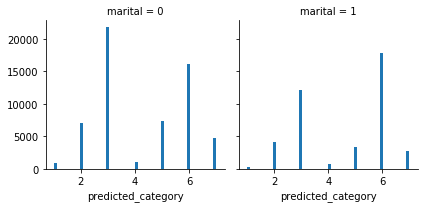

In [94]:
g = sns.FacetGrid(data=df_happy, col='marital')
g.map(plt.hist,'predicted_category', bins=50)

[]

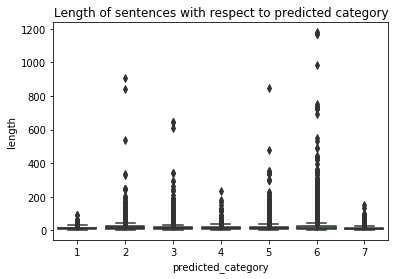

In [95]:
ax3 = sns.boxplot(x='predicted_category', y='length', data=df_happy, palette = 'viridis')
ax3.set(title = "Length of sentences with respect to predicted category")
ax3.plot()
# sns.boxplot(x='predicted_category', y='length', data=df_happy)



In [96]:
df_happy.describe()

,hmid,wid,num_sentence,predicted_category,length,reflection_period
count,100535.000000,100535.000000,100535.000000,100535.000000,100535.000000,100535.000000
mean,78213.756722,2746.619028,1.340767,4.413289,18.298503,0.504342
std,29178.959001,3535.010347,1.297159,1.688824,21.474146,0.499984
min,27673.000000,1.000000,1.000000,1.000000,2.000000,0.000000
25%,52941.500000,410.000000,1.000000,3.000000,9.000000,0.000000
50%,78204.000000,1125.000000,1.000000,5.000000,14.000000,1.000000
75%,103490.500000,3507.000000,1.000000,6.000000,21.000000,1.000000
max,128766.000000,13839.000000,69.000000,7.000000,1179.000000,1.000000


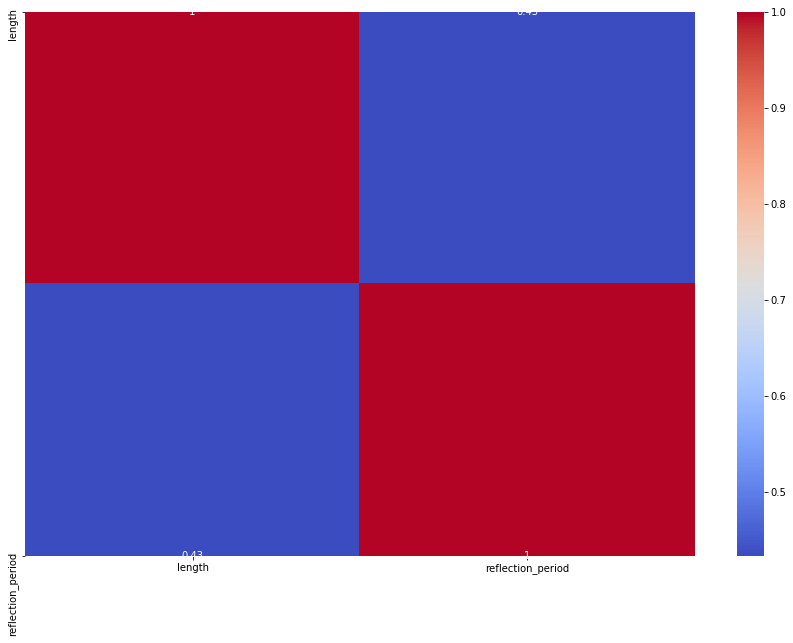

In [97]:
df_happy_new = df_happy.drop({'hmid', 'wid', 'num_sentence'}, axis=1)
fig, ax = plt.subplots(figsize=(15,10))
ax.set_yticklabels('auto', rotation='horizontal')
sns.heatmap(df_happy_new.groupby('predicted_category').mean().corr(), cmap='coolwarm',annot=True)

KeyError: ignored

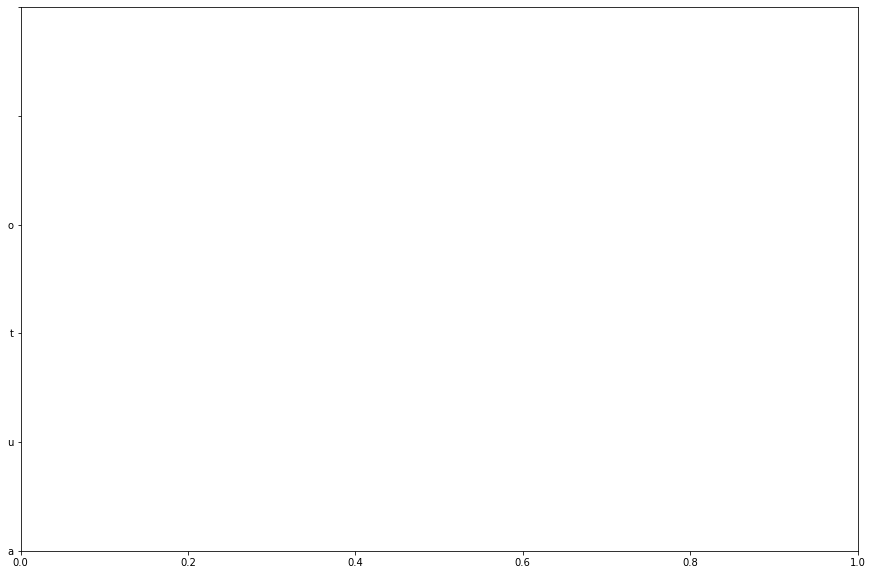

In [99]:
# plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

df_happy_new = df_happy.drop({'hmid', 'wid', 'num_sentence'}, axis=1)
fig, ax = plt.subplots(figsize=(15,10))
# plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

ax.set_yticklabels('auto', rotation='horizontal')
sns.heatmap(df_happy_new.groupby('piredicted_category').mean().corr(), cmap='coolwarm',annot=True)


**MultinomialNB Classifier for selected feature**

In [0]:
# Extract ith column of happy dataframe only for values equal to 0 or 1
i=9 # Selecting feature in this column (counting from 0) where column starts from 0 and 9 = marital status column
happy_class = df_happy[(df_happy.ix[:,i]==0) | (df_happy.ix[:,i]==1)]
# X = column 2 which is sentences = cleaned_hm
X=happy_class['cleaned_hm'] 
# Y = colum i = 9 which is marital status
y=happy_class.ix[:,i]
y = np.asarray(y,dtype=np.float64) # Convert y to float64 format

In [0]:
# print(type(happy_class))
# print(happy_class.head())
happy_class.columns
# print(type(X))
# X[:2]

In [0]:
# (df_happy.ix[:,i]==0).count()
# (df_happy.ix[:,i]==1).count()
# X = happy_class['cleaned_hm']
# print(type(y))
y
# j=5
# happy_class.ix[:,2]

In [38]:
CV = CountVectorizer()
print(type(CV))
print(CV)

<class 'sklearn.feature_extraction.text.CountVectorizer'>
CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)


In [0]:
X = CV.fit_transform(X) # Create vectors with frequency info for each rating text description


In [40]:
# print(type(X))
# print(X)
print(X[0,24602])

1


**Train Test Split and training model**

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)


In [42]:
print(type(X_train))
print(type(y_train))

<class 'scipy.sparse.csr.csr_matrix'>
<class 'numpy.ndarray'>


In [43]:
nb = MultinomialNB()
nb.fit(X_train, y_train)


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [44]:
predictions = nb.predict(X_test)

acc_nb = nb.score(X_test, y_test) # Return the mean accuracy
print('Classification Report - MNB \n',classification_report(y_test, predictions))
print('\n Confusion Matrix - MNB')
cm = pd.DataFrame(confusion_matrix(y_test, predictions), ['Actual: 0', 'Actual: 1'], ['Predicted: 0', 'Predicted: 1'])
print(cm)

Classification Report - MNB 
               precision    recall  f1-score   support

         0.0       0.70      0.83      0.76     17667
         1.0       0.67      0.49      0.57     12417

    accuracy                           0.69     30084
   macro avg       0.69      0.66      0.66     30084
weighted avg       0.69      0.69      0.68     30084


 Confusion Matrix - MNB
           Predicted: 0  Predicted: 1
Actual: 0         14741          2926
Actual: 1          6371          6046


In [45]:
predictions

array([1., 0., 0., ..., 0., 1., 1.])

In [0]:
# acc_nb


Prediction using Term Frequency, Inverse Document Frequency (TFIDF), then applying the same MultinomialNB Classifier

In [0]:
pipeline = Pipeline([
    ('bow', CountVectorizer()),
	('tfidf', TfidfTransformer()),
	('Classifier', MultinomialNB())
	])

# CountVectorizer == creating CSR matrix in form of count of each word in a sentence.
# TfidfTransformer == conver the CSR matrix in normalized form only for non-zero vaules
# Classifier == model name

In [0]:
# pipeline = Pipeline([
#     ('bow', CountVectorizer()),
# 	('tfidf', TfidfTransformer()),
# 	('Classifier', MultinomialNB())
# 	])

In [0]:
# Extract ith column of happy dataframe only for values equal to 0 or 1
i=9 # Selecting feature in this column (counting from 0)
happy_class = df_happy[(df_happy.ix[:,i]==0) | (df_happy.ix[:,i]==1)]
X=happy_class['cleaned_hm']
y=happy_class.ix[:,i]
y = np.asarray(y,dtype=np.float64) # Convert y to float64 format
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)


In [49]:
pipeline.fit(X_train, y_train)


Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('Classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [50]:
predictions = pipeline.predict(X_test)
print('Classification Report - MNB Demographics\n',classification_report(y_test, predictions))
print('\n Confusion Matrix - MNB DEmographics')
cm = pd.DataFrame(confusion_matrix(y_test, predictions), ['Actual: 0', 'Actual: 1'], ['Predicted: 0', 'Predicted: 1'])
print(cm)

Classification Report - MNB Demographics
               precision    recall  f1-score   support

         0.0       0.67      0.92      0.77     17667
         1.0       0.75      0.35      0.48     12417

    accuracy                           0.68     30084
   macro avg       0.71      0.63      0.63     30084
weighted avg       0.70      0.68      0.65     30084


 Confusion Matrix - MNB DEmographics
           Predicted: 0  Predicted: 1
Actual: 0         16234          1433
Actual: 1          8071          4346


Evaluating prediction accuracies for multiple features

Predictions for country, gender, marital, parenthood, 3m or 24h

In [0]:
# Index(['hmid', 'wid', 'cleaned_hm', 'num_sentence', 'predicted_category',
#        'length', 'age', 'country', 'gender', 'marital', 'parenthood',
#        'reflection_period'],
#       dtype='object')

In [52]:
# Apply MultinomialNB classifier to other features, save scores for display
# Same logic as above but for each feature
accuracies_data=np.arange(6.0) # Create dataframe accuracies_data to store all scores

for i in range(6,12):
    # 1 Extract column i of happy dataframe only for values equal to 0 or 1, then split test from train data
    happy_class = df_happy[(df_happy.ix[:,i]==0) | (df_happy.ix[:,i]==1)]
    X = happy_class['cleaned_hm'] # Text column only
    y = happy_class.ix[:,i]
    y = np.asarray(y, dtype=np.float64)
    # Create vectors with frequency info for each text description
    CV = CountVectorizer()
    X  = CV.fit_transform(X) # creates vectors with frequency info for each rating text description
    
    # 2 Train Test Split, create instance and train classifier
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
    nb = MultinomialNB()
    nb.fit(X_train, y_train)
    predictions = nb.predict(X_test)
    accuracies_data[i-6] = nb.score(X_test, y_test)
accuracies_data

array([0.80737174, 0.87211817, 0.66265781, 0.6909653 , 0.70267397,
       0.64599037])

In [0]:
# # Apply MultinomialNB classifier to other features, save scores for display
# # Same logic as above but for each feature
# accuracies_data=np.arange(5.0) # Create dataframe accuracies_data to store all scores

# for i in range(7,12):
#     # 1 Extract column i of happy dataframe only for values equal to 0 or 1, then split test from train data
#     happy_class = df_happy[(df_happy.ix[:,i]==0) | (df_happy.ix[:,i]==1)]
#     X = happy_class['cleaned_hm'] # Text column only
#     y = happy_class.ix[:,i]
#     y = np.asarray(y, dtype=np.float64)
#     pipeline = Pipeline([
#     ('bow', CountVectorizer()),
# 	('tfidf', TfidfTransformer()),
# 	('Classifier', MultinomialNB())
# 	])
#     # Create vectors with frequency info for each text description
#     # CV = CountVectorizer()
#     # X  = CV.fit_transform(X) # creates vectors with frequency info for each rating text description
    
#     # 2 Train Test Split, create instance and train classifier
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
#     pipeline.fit(X_train, y_train)
#     predictions = pipeline.predict(X_test)
#     print('Classification Report \n',classification_report(y_test, predictions))
#     print('\n Confusion Matrix')
#     cm = pd.DataFrame(confusion_matrix(y_test, predictions), ['Actual: 0', 'Actual: 1'], ['Predicted: 0', 'Predicted: 1'])
#     print(cm)

#     # nb = MultinomialNB()
#     # nb.fit(X_train, y_train)
#     # predictions = nb.predict(X_test)
#     # accuracies_data[i-7] = nb.score(X_test, y_test)
# accuracies_data

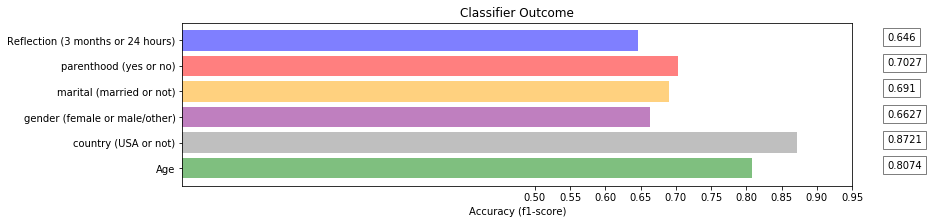

In [54]:
# Display results
accuracies_data = accuracies_data.round(4) # Round all values to 4 digits
objects = ('Age',
           'country (USA or not)',
           'gender (female or male/other)',
           'marital (married or not)',
           'parenthood (yes or no)',
           'Reflection (3 months or 24 hours)')
y_pos = np.arange(len(objects))   
plt.figure(figsize=(12,3))
plt.barh(y_pos, accuracies_data, left = 0, align='center', alpha=0.5,
         color=['green', 'grey', 'purple', 'orange', 'red','blue'], tick_label= accuracies_data)
plt.yticks(y_pos, objects, rotation='horizontal')
plt.xticks(np.arange(0.5, 1, step=0.05))
#plt.axes([0.2,0.1,0.9,0.9])
plt.xlabel('Accuracy (f1-score)')
for i, v in enumerate(accuracies_data):
    plt.text(1, i, str(v), color='black', bbox=dict(facecolor='white', alpha=0.5))
plt.title('Classifier Outcome')
plt.show()


In [0]:
df_happy = pd.read_csv('happydb/cleaned_hm.csv')
df_happy=df_happy.head(5000) # Development/Testing: 5000
demographic = pd.read_csv('demographic_cleaned.csv')
#demographic = demographic[1:50000] #.sample(frac=0.1
# List of common words to remove, many thanks Chen-Chen for the initial inputs
nolist = ['happy', 'day', 'got', 'went', 'today', 'made', 'one', 'two', 'time', 'last', 'first', 'going',
'getting', 'took', 'found', 'lot', 'really', 'saw', 'see', 'month', 'week', 'day', 'yesterday',
'year', 'ago', 'now', 'still', 'since', 'something', 'great', 'good', 'long', 'thing', 'toi', 'without',
'yesteri', '2s', 'toand', 'ing', 'got', 'came', 'could', 'happiness', 'new', 'able', 'finally', 'like',
'old', 'years', 'many', '2', 'get', 'taj', 'nice', 'top', 'back']

df_happy = pd.merge(df_happy, demographic, on='wid')
df_happy.drop('age', axis=1, inplace=True)

Key words analysis for all labels of multiple features

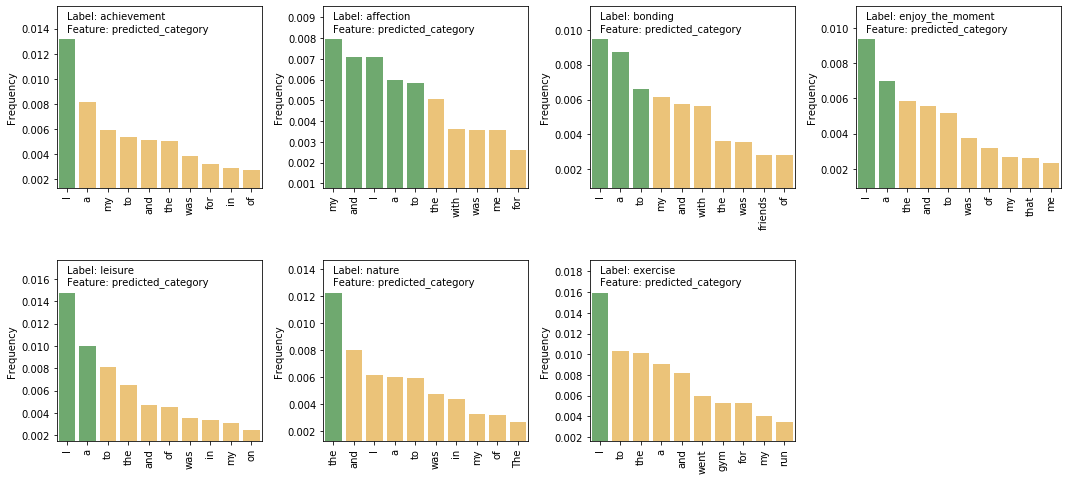

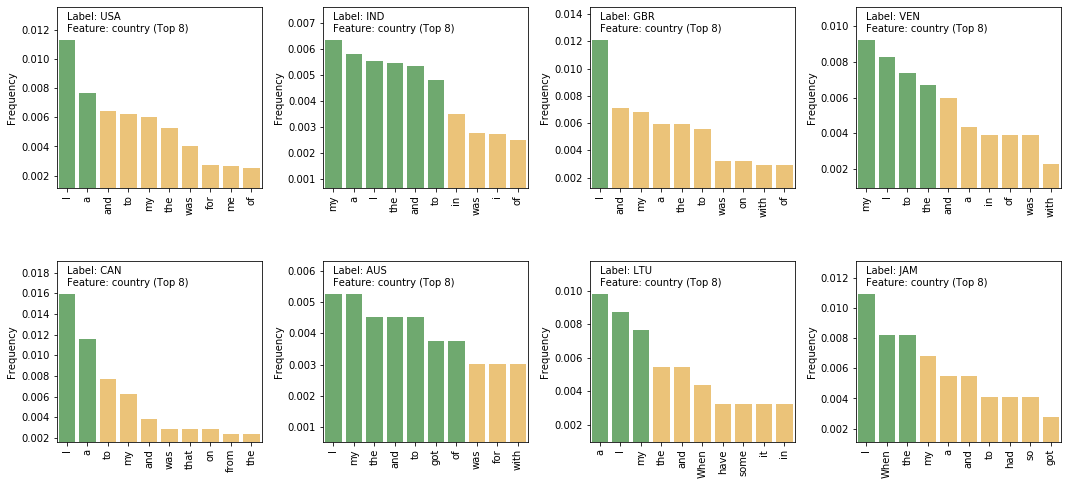

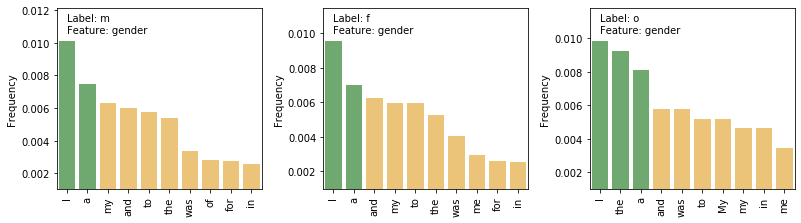

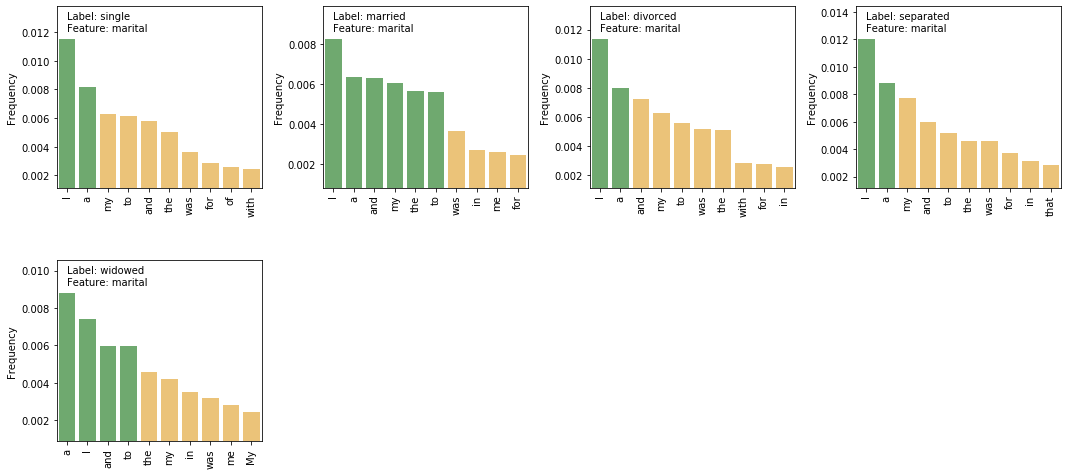

In [56]:
for k in range(8, 12): # Feature k
    
    # Extract unique values of predicted_category and add to a list in descending orders (by count of responses)
    pivot_category = pd.pivot_table(df_happy, values='hmid',index=df_happy.ix[:,k], aggfunc='count')
    pivot_category.sort_values('hmid', axis=0, ascending=False, inplace=True, kind='quicksort', na_position='last')
    Category_labels =pivot_category.T.columns.tolist()
    add_title = ''
    if len(Category_labels)>10:
        Category_labels = Category_labels[0:8]
        add_title = '(Top 8)'

    j = 0 # Labels j for selected features
    str5={0:[]}
    fig = plt.figure(figsize=(18, 8))
    plt.title('Feature: '+df_happy.columns[k])
    fig.subplots_adjust(hspace=0.4, wspace=0.3)

    #fig, axis = plt.subplots(1,len(Category_labels),figsize=(18,3))
    for j in range(0, len(Category_labels)):
        l=j+1
        text = ' '.join(df_happy[df_happy.ix[:,k]==Category_labels[j]]['cleaned_hm'].tolist())
        str = text.split()         
        str2 = []
        str3 = pd.DataFrame([['A','B']], [Category_labels[j]], ['Word','Frequency'])
    
    # Check for duplicate by looping until string values is not present in str
        for word in str:
            if (word not in str2) & ((word+'s') not in str2):
                str2.append(word) # insert value in str2

    # Create dataframe to store and report results
        str3.ix[0][0]=str2[0]
        str3.ix[0][1]=str.count(str2[0]) / len(text)
        for i in range(1, len(str2)):
            # count the frequency of each word(present # in str2 and add with word to DataFrame
            freq = str.count(str2[i]) / len(text) 
            str4 = pd.DataFrame([[str2[i],freq]], [Category_labels[j]], ['Word','Frequency'])
            str3 = str3.append(str4)  

        str3.sort_values(by = 'Frequency', ascending=False, inplace=True)
        str4 = str3.head(10)
        str5.update({j: str4}) #add result to the list str 5 to create graphs in next section 
    
        # Graphing
        plt.subplot(2, 4, l)
        objects = str5[j]['Word']
        x_pos = np.arange(len(objects))   
        colors = tuple(np.where(str5[j]['Frequency']>(0.66*str5[j]['Frequency'].max()), 'g', 'orange'))
        sns.barplot(x=x_pos, y=str5[j]['Frequency'], palette=colors, alpha=0.6, data=df_happy);
        plt.text(0, (str5[j]['Frequency'].max()*1.05), 'Label: ' + Category_labels[j]
        +'\nFeature: '+df_happy.columns[k]+' '+add_title)
        plt.ylim((str5[j]['Frequency'].max()*0.1), (str5[j]['Frequency'].max()*1.2))
        plt.xticks(x_pos, objects, rotation=90)

plt.show()

# Random OverSampling



In [0]:
# XTrain = pd.read_pickle("./XTrain_Cleaned_hm_11_15.pkl")
# XTest = pd.read_pickle("./XTest_Cleaned_hm_11_15.pkl")
# yTrain = pd.read_pickle("./yTrain_prediction_11_15.pkl")
# yTest = pd.read_pickle("./yTest_prediction_11_15.pkl")
# cv_train = pd.read_pickle("./cv_train_CSR_Matrix_11_15.pkl")
# cv_test = pd.read_pickle("./cv_test_CSR_Matrix_11_15.pkl")

In [0]:
df_happy = pd.read_csv('happydb/cleaned_hm.csv')
df_happy=df_happy.head(5000) # Development/Testing: 5000
demographic = pd.read_csv('demographic_cleaned.csv')
#demographic = demographic[1:50000] #.sample(frac=0.1
# List of common words to remove, many thanks Chen-Chen for the initial inputs
nolist = ['happy', 'day', 'got', 'went', 'today', 'made', 'one', 'two', 'time', 'last', 'first', 'going',
'getting', 'took', 'found', 'lot', 'really', 'saw', 'see', 'month', 'week', 'day', 'yesterday',
'year', 'ago', 'now', 'still', 'since', 'something', 'great', 'good', 'long', 'thing', 'toi', 'without',
'yesteri', '2s', 'toand', 'ing', 'got', 'came', 'could', 'happiness', 'new', 'able', 'finally', 'like',
'old', 'years', 'many', '2', 'get', 'taj', 'nice', 'top', 'back']

df_happy = pd.merge(df_happy, demographic, on='wid')
df_happy.drop('age', axis=1, inplace=True)

In [59]:
# Apply MultinomialNB classifier to other features, save scores for display
# Same logic as above but for each feature
accuracies_data=np.arange(6.0) # Create dataframe accuracies_data to store all scores

for i in range(6,12):
    # 1 Extract column i of happy dataframe only for values equal to 0 or 1, then split test from train data
    happy_class = df_happy[(df_happy.ix[:,i]==0) | (df_happy.ix[:,i]==1)]
    X = happy_class['cleaned_hm'] # Text column only
    y = happy_class.ix[:,i]
    y = np.asarray(y, dtype=np.float64)
    # Create vectors with frequency info for each text description
    CV = CountVectorizer()
    X  = CV.fit_transform(X) # creates vectors with frequency info for each rating text description
    
    # 2 Train Test Split, create instance and train classifier
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
    nb = MultinomialNB()
    nb.fit(X_train, y_train)
    predictions = nb.predict(X_test)
    accuracies_data[i-6] = nb.score(X_test, y_test)
accuracies_data

ValueError: ignored

In [0]:
# Display results
accuracies_data = accuracies_data.round(4) # Round all values to 4 digits
objects = ('Age',
           'country (USA or not)',
           'gender (female or male/other)',
           'marital (married or not)',
           'parenthood (yes or no)',
           'Reflexion (3 months or 24 hours)')
y_pos = np.arange(len(objects))   
plt.figure(figsize=(12,3))
plt.barh(y_pos, accuracies_data, left = 0, align='center', alpha=0.5,
         color=['green', 'grey', 'purple', 'orange', 'red','blue'], tick_label= accuracies_data)
plt.yticks(y_pos, objects, rotation='horizontal')
plt.xticks(np.arange(0.5, 1, step=0.05))
#plt.axes([0.2,0.1,0.9,0.9])
plt.xlabel('Accuracy (f1-score)')
for i, v in enumerate(accuracies_data):
    plt.text(1, i, str(v), color='black', bbox=dict(facecolor='white', alpha=0.5))
plt.title('Classifier Outcome')
plt.show()
